In [1]:
#importing the requests library
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

Using [marketstack](https://marketstack.com/?utm_source=Geekflare&utm_medium=LeadsAcquisition&utm_content=Listing) to make API calls to retrieve end-of-day stock price of your preferred company.

API documentations can be found [here](https://marketstack.com/documentation). Code examples for different languages can be found [here](https://marketstack.com/documentation#php)

In [2]:
def enter_ticker(symbol):
    #making the request
    url = 'http://api.marketstack.com/v1/eod'
    params = {
        'access_key' : '038908b69357069eadcfc963cbafe6ee',
        'symbols' : symbol,
        'limit' : 600
         }
    resp = requests.get(url,params=params)
    data = resp.json()
     
    df = pd.DataFrame(data=data['data'])
    df['date'] = df['date'].astype('datetime64[ns]')
    df.set_index('date',inplace=True)
    return df

In [3]:
def viz(ticker_df):
    info_df = ticker_df.loc[:,['close','volume']]
    scaler = StandardScaler()
    scaled_df = pd.DataFrame(data=scaler.fit_transform(info_df),columns=info_df.columns,index=info_df.index)
    return scaled_df.plot(figsize=(12,8))

### calculating stock returns

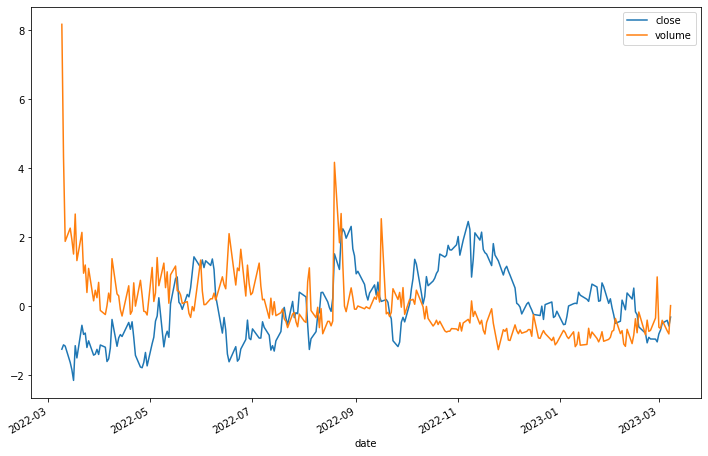

In [4]:
oxy = enter_ticker('OXY')
oxy_viz = viz(oxy)

In [5]:
oxy_close = oxy[['close']]
oxy_close['pct_change'] = oxy_close['close'].pct_change(1)
oxy_close

,close,pct_change
date,,
2023-03-08,62.15,NaN
2023-03-07,60.85,-0.020917
2023-03-06,61.68,0.013640
2023-03-03,61.25,-0.006971
2023-03-02,60.27,-0.016000
...,...,...
2022-03-15,54.53,0.029062
2022-03-14,55.59,0.019439
2022-03-11,57.95,0.042454


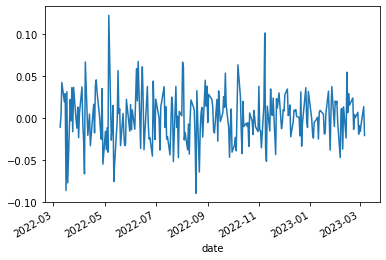

In [8]:
oxy_close['pct_change'].plot();

In [20]:
spy = enter_ticker('SPY')
spy_close = spy[['close']]
spy_close['pct_change'] = spy_close.pct_change
spy_close

RecursionError: maximum recursion depth exceeded in __instancecheck__

RecursionError: maximum recursion depth exceeded in __instancecheck__

## stock evaluation

1. risk - need to calculate beta ratio
2. p/e ratio
3. p/b ratio
4. div yield

A stock’s beta measures how risky, or volatile, a stock’s price is compared to the entire market.
When beta is less than 1, a stock is less volatile, or less risky than the market.
The opposite holds true when beta is greater than 1, showing the stock would be more volatile, or riskier than the market.
A beta equal to 1 represents a stock that has equal risk and volatility as the market.

In [18]:
#delete the first row since linear regression will not accept Nan values
oxy_close = oxy_close.drop(oxy_close.index[0])
oxy_close

,close,pct_change
date,,
2023-03-07,60.85,-0.020917
2023-03-06,61.68,0.013640
2023-03-03,61.25,-0.006971
2023-03-02,60.27,-0.016000
2023-03-01,59.71,-0.009292
...,...,...
2022-03-15,54.53,0.029062
2022-03-14,55.59,0.019439
2022-03-11,57.95,0.042454
